In [1]:
import ForwardDiff
import PyPlot
using PyPlot

INFO: Precompiling module PyPlot...


In [2]:
function make_bins(B, dx)
    # B = params[1]
    bins = collect(1.0:binN)*B
    bins = dx*bins/B

    if bins[end] == B
        bins[end] = B + dx
    else
        bins[end] = 2*B - bins[end-1]
    end

    bins = [-bins[end:-1:1]; 0; bins]
    return bins
end;

In [4]:
function Fmatrix(params::Vector)
    sigma = params[1];
    lam   = params[2];
    c     = params[3];

    F = collect(1.0:length(bin_centers))*collect(1.0:length(bin_centers))';
    F = 0.0*sigma*F; # Multiplying by that sigma is needed, for type casting reasons I do not understand...

    mus      = (bin_centers + c/lam)*exp(lam*dt) - c/lam
    sbinsize = 0.1*sqrt(sigma_sbin^2*dt)
    swidth   = 4*sqrt((sigma_sbin/dx)^2*dt)
    sbins    = collect(-swidth:sbinsize:swidth+epsilon)
    ps       = exp(-sbins.^2/(2*sigma^2*dt)) / sqrt(2*sigma^2*dt)
    ps       = ps/sum(ps);

    base_sbins = sbins;

    for j in 1:length(bin_centers)
        # sbins = [mus[j] - swidth : sbinsize : mus[j] + swidth+epsilon]
        sbins = collect(0:(length(base_sbins)-1))*sbinsize
        sbins = sbins + mus[j]-swidth

        for k in 1:length(sbins)
            if sbins[k] < (bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif (bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else
                bot = find(bin_centers .<= sbins[k])[end]
                top = bot+1
                #display(bot)
                #display(top)
                F[bot,j] = F[bot,j] + ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bot])
                F[top,j] = F[top,j] + ps[k]*(sbins[k] - bin_centers[bot])/(bin_centers[top] - bin_centers[bot])
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
    return F
end

Fmatrix (generic function with 1 method)

In [5]:
probRight(params)

LoadError: LoadError: UndefVarError: probRight not defined
while loading In[5], in expression starting on line 1

In [6]:
function probRight(params::Vector)
    sigma_a = params[1]*sqrt(dt)/dx; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    global a, c, a_trace, c_trace
    global bin_centers  # remember, lexical scoping! When Fmatrix was defined, the relevant
    # bin_centers was the global one, so making a local one here won't affect Fmatrix. 
    global binN
    
    bin_centers = make_bins(B, dx)
    a = zeros(length(bin_centers),1)*sigma_a*0.0; # That weirdo inexact error thing
    a[binN+1] = 1-2*lapse; a[1] = lapse; a[end] = lapse;
    c_eff   = 1;

    Fi = Fmatrix(collect([sigma_i/dx; lambda; 0.0])); a = Fi*a;

    F0 = Fmatrix(collect([sigma_a; lambda; 0.0]))
    for i in 1:(Nsteps-1) 
        c_eff = 1 + (c_eff - 1)*exp(-dt/tau_phi)
        if c[i]==0
            a = F0*a
        else
            F = Fmatrix(collect([sigma_a; lambda; c_eff/dt]))
            a = F*a
            c_eff = c_eff*phi
        end
    end;
    pright = sum(a[binBias+1:end]) + 
        a[binBias]*0.5*(dx/2 - (bias - bin_centers[binBias]))/(dx/2)
    return pright
end

probRight (generic function with 1 method)

In [25]:
binN

16

In [7]:
"""
function probRight_noderiv(params::Vector)

Copy of probRight, but keeps some traces and does NOT play nice with ForwardDiff

Uses globals 
    Nsteps number fo timesteps to simulate
    a      (column vector representing distribution of values of accumulator a)
    c      (vector, Nsteps long, with 1s whereever there were clicks, 0s otherwise)
    bin_centers   (column vector of bin centers for a)
    binN   (the bin_centers bin centered on representing a=0)

    a_trace (length(bin_centers)-by-Nsteps), a trace of the distribution of a as a function of time
    c_trace (row vector Nsteps long, effective value of c as a function of time after adaptation)

Takes params
    sigma_a = params[1]*sqrt(dt)/dx; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]

Returns the probability that the agent chose Right. 
"""

function probRight_noderiv(params::Vector)
    sigma_a = params[1]*sqrt(dt)/dx; sigma_s = params[2]; sigma_i = params[3]; 
    lambda = params[4]; B = params[5]; bias = params[6]; 
    phi = params[7]; tau_phi = params[8]; lapse = params[9]
    global a, c, a_trace, c_trace
    global bin_centers  # remember, lexical scoping! When Fmatrix was defined, the relevant
    # bin_centers was the global one, so making a local one here won't affect Fmatrix. 
    global binN
    
    bin_centers = make_bins(B, dx)
    a = zeros(length(bin_centers),1)*sigma_a*0.0; # That weirdo inexact error thing
    a[binN+1] = 1-2*lapse; a[1] = lapse; a[end] = lapse;
    c_eff   = 1;

    Fi = Fmatrix(collect([sigma_i/dx; lambda; 0.0])); a = Fi*a;
    a_trace[:,1] = a;

    F0 = Fmatrix(collect([sigma_a; lambda; 0.0]))
    for i in 1:(Nsteps-1) 
        c_eff = 1 + (c_eff - 1)*exp(-dt/tau_phi)
        c_trace[i] = c_eff
        if c[i]==0
            a = F0*a
        else
            F = Fmatrix(collect([sigma_a; lambda; c_eff/dt]))
            a = F*a
            c_eff = c_eff*phi
        end
        a_trace[:,i+1] = a
    end;
    pright = sum(a[binBias+1:end]) + 
        a[binBias]*0.5*(dx/2 - (bias - bin_centers[binBias]))/(dx/2)
    return pright
end

probRight_noderiv (generic function with 1 method)

0.9110432813785019

9x9 Array{Float64,2}:
 -0.0136179    0.0  -0.000155463   0.0408979    …  -0.0887009    0.14125    
  0.0          0.0   0.0           0.0              0.0          0.0        
 -0.000155463  0.0  -0.0305793    -0.00733856      -0.0200206    0.0340029  
  0.0408979    0.0  -0.00733856   -0.0489462        0.0697856   -0.102224   
 -6.04223e-9   0.0  -1.76213e-9    6.64557e-10      4.23679e-9   9.56521e-10
 -0.100419     0.0  -0.024284      0.150828     …  -0.213121     0.242308   
  0.0158394    0.0   0.00357511   -0.0124617        0.130868    -0.0363523  
 -0.0887009    0.0  -0.0200206     0.0697856        0.183216     0.203573   
  0.14125      0.0   0.0340029    -0.102224         0.203573     0.0        

0.9110432813785019

2.4399131878232865

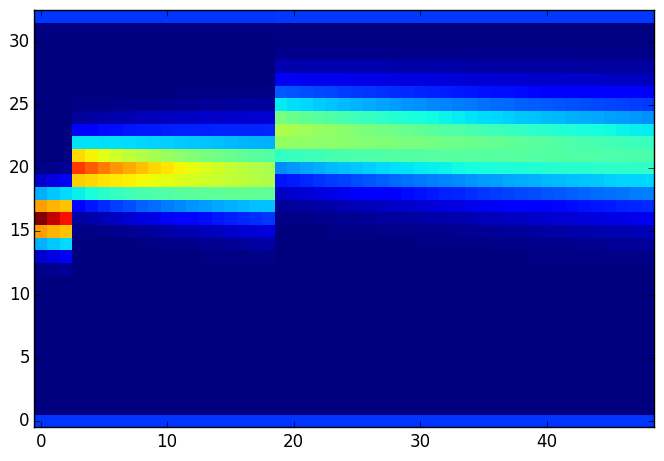

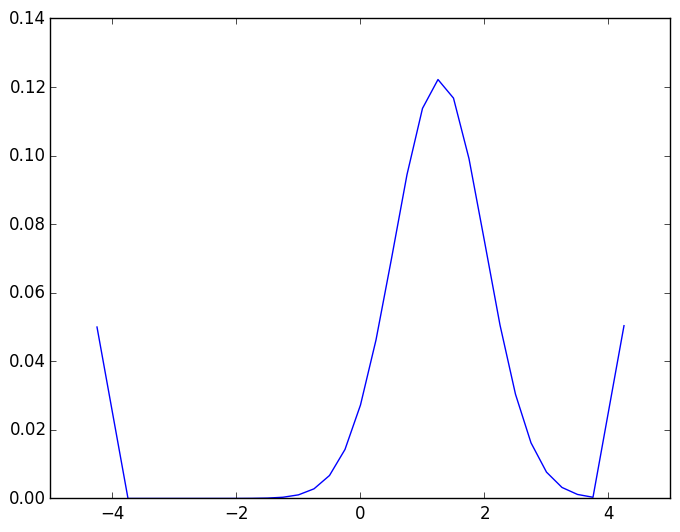

In [8]:
epsilon = 10.0^(-10); dx = 0.25; dt = 0.02; Nsteps = Int(ceil(1.0/dt))

# ------  sigma_i is now in proper accumulator units, but sigma_a needs to be converted
#         to reasonable units; and sigma_s has not been implemented yet.
#                Currently debugging the sigma_s units
# --------------------------------------------------------------------------------------
sigma_a = 1; sigma_s = 0; sigma_i = 0.5; 
sigma_sbin = sigma_a;  # remember we need this copy for Fmatrix
lam = -0.5; B = 4; bias = 0; 
phi = 0.3; tau_phi = 0.2; lapse = 0.05;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse]   
# sigma_a, sigma_i, sigma_s;  phi, tau_phi;  lapse, bias

binN = Int(ceil(B/dx))  # ForwardDiff doesn't know how to deal with ceil(), 
bin_centers = make_bins(B, dx)
binBias = Int(floor(bias/dx)) + binN+1  # again, ForwardDiff can't deal with floor()
a = zeros(length(bin_centers),1); a[binN+1] = 1
c = zeros(1, Nsteps); c[[Int(ceil(0.08/dt)), Int(ceil(0.4/dt))]] = 1;
a_trace = zeros(length(bin_centers), Nsteps); c_trace = zeros(1, Nsteps)

display(probRight(params))
display(ForwardDiff.hessian(probRight, params))
display(probRight_noderiv(params))

figure(1)
imshow(a_trace[:,2:end], interpolation="none", origin="lower")# , extent=(0, (Nsteps-1), -B, B))
figure(2)
plot(bin_centers, a)
mu = sum(bin_centers.*a) 
sd = sum(bin_centers.*bin_centers.*a)
sd = sd - mu.^2
display(sd)
# display(std(a))  Make sure to measure that <a.^2> is roughly the same for dx=0.25 and dx=1